## K2TranPix tester

In [1]:
#from ipywidgets import interact, interactive, fixed, interact_manual
#import ipywidgets as widgets
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from astropy.io import fits
from glob import glob

from scipy.signal import convolve2d
from scipy.ndimage.filters import convolve
from scipy.interpolate import interp1d
from astropy.wcs import WCS
from tqdm import tnrange, tqdm_notebook
import warnings
warnings.filterwarnings("ignore",category = RuntimeWarning)
%matplotlib inline
%matplotlib notebook

In [155]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.gridspec as gridspec
import numpy as np

from scipy.ndimage.filters import convolve
from scipy.interpolate import interp1d

from astropy.io import fits
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS

from astroquery.simbad import Simbad
from astroquery.ned import Ned
from astroquery.ned.core import RemoteServiceError
from xml.parsers.expat import ExpatError
from astropy import coordinates
import astropy.units as u

from glob import glob
import os
import time as t

import warnings
warnings.filterwarnings("ignore",category =RuntimeWarning)
warnings.filterwarnings("ignore",category = UserWarning)



def DriftKiller(data,thrust):
    # The right value choice here is a bit ambiguous, though it seems that typical variations are <10.
    Drift = (abs(data[thrust+1]-data[thrust-1]) < 10)*1.0 
    Drift[Drift == 0] = np.nan
    j = 0
    for i in range(len(thrust)):
        data[j:thrust[i]] = data[j:thrust[i]]*Drift[i]
        j = thrust[i]
    return data

def FindMinFrame(data,thrusters):
    # Finding the reference frame
    Framemin = data[thrusters[3]+1]
    return Framemin

def ObjectMask(datacube,Framemin):
    # Make a mask of the target object, using the reference frame 
    Mask = datacube[Framemin,:,:]/(np.nanmedian(datacube[Framemin,:,:])+np.nanstd(datacube[Framemin,:,:]))
    Mask[Mask>=1] = np.nan
    Mask[Mask<1] = 1
    # Generate a second mask from remainder of the first. This grabs the fainter pixels around known sources
    Maskv2 = datacube[Framemin,:,:]*Mask/(np.nanmedian(datacube[Framemin,:,:]*Mask)+np.nanstd(datacube[Framemin,:,:]*Mask))
    Maskv2[Maskv2>=1] = np.nan
    Maskv2[Maskv2<1] = 1
    return Maskv2

def ThrustObjectMask(data,thrust):
    StartMask = np.ones((data.shape[1],data.shape[2]))
    for i in range(2):
        Start = data[thrust[:3]+1]*StartMask/(np.nanmedian(data[thrust[:3]+1]*StartMask, axis = (1,2))+np.nanstd(data[thrust[:3]+1]*StartMask, axis = (1,2)))[:,None,None]
        Start = Start >= 1
        temp = (np.nansum(Start*1, axis = 0) >=1)*1.0
        temp[temp>=1] = np.nan
        temp[temp<1] = 1
        StartMask = StartMask*temp


    EndMask = np.ones((data.shape[1],data.shape[2]))
    for i in range(2):
        End = data[thrust[-3:]+1]*EndMask/(np.nanmedian(data[thrust[-3:]+1]*EndMask, axis = (1,2))+np.nanstd(data[thrust[-3:]+1]*EndMask, axis = (1,2)))[:,None,None]
        End = End >= 1
        temp = (np.nansum(End*1, axis = 0) >=1)*1.0
        temp[temp>=1] = np.nan
        temp[temp<1] = 1
        EndMask = EndMask*temp
    
        
    Mask = np.nansum([np.ma.masked_invalid(StartMask).mask,np.ma.masked_invalid(EndMask).mask],axis=(0))*1.0
    Mask[Mask!=2] = 1
    Mask[Mask==2] = np.nan
    return Mask



def EventSplitter(events,Times,Masks,framemask):
    Events = []
    times = []
    mask = []
    for i in range(len(events)):
        # Check if there are multiple transients
        Coincident = Masks[events[i]]*framemask[events[i]]*1
        positions = np.where(Coincident == 1)
        if len(positions[0]) > 1:
            for p in range(len(positions[0])):
                eventmask = np.zeros((Masks.shape[1],Masks.shape[2]))
                eventmask[positions[0][p],positions[1][p]] = 1
                eventmask = convolve(eventmask,np.ones((3,3)),mode='constant', cval=0.0)
                Similar = np.where((Masks[Times[i][0]:,:,:]*eventmask == eventmask).all(axis=(1,2)))[0]
                
                if len((np.diff(Similar)<5)) > 1:
                    
                    if len(np.where((np.diff(Similar)<5) == False)[0]) > 0:
                        SimEnd = np.where((np.diff(Similar)<5) == False)[0][0] 
                    else:
                        SimEnd = -1
                else:
                    SimEnd = 0

                Similar = Similar[:SimEnd]
                if len(Similar) > 1:
                    timerange = [Similar[0]+Times[i][0]-1,Similar[-1]+Times[i][0]+1]
                    if len(timerange) > 1:
                        Events.append(events[i])
                        times.append(timerange)
                        mask.append(eventmask)
                
        else:
            Events.append(events[i])
            times.append(Times[i])
            mask.append(Masks[events[i]])
            

    return Events, times, mask

def Asteroid_fitter(Mask,Time,Data, plot = False):
    lc = np.nansum(Data*Mask,axis=(1,2))
    middle = np.where(np.nanmax(lc[Time[0]-1:Time[-1]+1]) == lc)[0][0]
    if abs(Time[0] - Time[1]) < 4:
        x = np.arange(middle-1,middle+1+1,1)
    else:
        x = np.arange(middle-2,middle+2+1,1)
    if x[-1] > len(lc) - 1:
        x = x[x<len(lc)]
    x2 = np.arange(0,len(x),1)
    if np.nanmedian(lc[x]) >0:
        y = lc[x]/np.nanmedian(lc[x])
        p1, residual, _, _, _ = np.polyfit(x,y,2, full = True)
        p2 = np.poly1d(p1)
        AvLeft = np.nansum(abs(lc[Time[0]:Time[-1]]/np.nanmedian(lc[x]) - p2(np.arange(Time[0],Time[-1]))))/(Time[-1]-Time[0])
        maxpoly = np.where(np.nanmax(p2(x)) == p2(x))[0][0]
        if (AvLeft < 2) &  (abs(middle - x[maxpoly]) < 2):
            asteroid = True
            if plot == True:
                p2 = np.poly1d(p1)
                plt.figure()
                plt.plot(x,y,'.',label='Event LC')
                plt.plot(x,p2(x),'kx',label='Parabola fit')
                plt.axvspan(Time[0],Time[1], color = 'orange',alpha=0.5, label = 'Event duration')
                plt.ylabel('Counts')
                plt.xlabel('Time')
                plt.legend()
                plt.title('Residual = ' + str(AvLeft))
                #plt.savefig('Asteroid_paper_example.pdf')
        else:
            asteroid = False
    else:
        asteroid = False

    return asteroid

def Smoothmax(interval,Lightcurve,qual):
    x = np.arange(interval[0],interval[1],1.)
    x[qual[interval[0]:interval[-1]]!=0] = np.nan 
    nbins = int(len(x)/5)
    y = np.copy(Lightcurve[interval[0]:interval[-1]])
    y[qual[interval[0]:interval[-1]]!=0] = np.nan
    
    if np.nansum(x) > 0:
        n, _ = np.histogram(x, bins=nbins,range=(np.nanmin(x),np.nanmax(x)))
        sy, _ = np.histogram(x, bins=nbins, weights=y,range=(np.nanmin(x),np.nanmax(x)))
        sy2, _ = np.histogram(x, bins=nbins, weights=y*y,range=(np.nanmin(x),np.nanmax(x)))
        mean = sy / n
        std = np.sqrt(sy2/n - mean*mean)

        xrange = np.linspace(np.nanmin(x),np.nanmax(x),len(x))
        y_smooth = np.interp(xrange, (_[1:] + _[:-1])/2, mean)
        y_smooh_error = np.interp(xrange, (_[1:] + _[:-1])/2, std)

        temp = np.copy(y)
        temp[y_smooh_error>10] =np.nan

        maxpos = np.where(temp == np.nanmax(temp))[0]+interval[0]
    else:
        maxpos = 0
    return maxpos

def ThrusterElim(Events,Times,Masks,Firings,Quality,qual,Data):
    temp = []
    temp2 = []
    temp3 = []
    asteroid = []
    asttime = []
    astmask = []
    for i in range(len(Events)):
        Range = Times[i][-1] - Times[i][0]
        if (Range > 0) & (Range/Data.shape[0] < 0.8) & (Times[i][0] > 5): 
            begining = Firings[(Firings >= Times[i][0]-2) & (Firings <= Times[i][0]+1)]
            if len(begining) == 0:
                begining = Quality[(Quality == Times[i][0])] #& (Quality <= Times[i][0]+1)]
            end = Firings[(Firings >= Times[i][-1]-1) & (Firings <= Times[i][-1]+2)]
            if len(end) == 0:
                end = Quality[(Quality == Times[i][-1])] #& (Quality <= Times[i][-1]+1)]
            eventthrust = Firings[(Firings >= Times[i][0]) & (Firings <= Times[i][-1])]

            if (~begining.any() & ~end.any()) & (len(eventthrust) < 3):
                
                if Asteroid_fitter(Masks[i],Times[i],Data):
                    asteroid.append(Events[i])
                    asttime.append(Times[i])
                    astmask.append(Masks[i])
                else:
                    LC = np.nansum(Data[Times[i][0]:Times[i][-1]+3]*Masks[i], axis = (1,2))
                    if (np.where(np.nanmax(LC) == LC)[0] < Range).all():
                    
                        temp.append(Events[i])
                        temp2.append(Times[i])
                        temp3.append(Masks[i])

            elif len(eventthrust) >= 3:

                if begining.shape[0] == 0:
                    begining = 0
                else:
                    begining = begining[0]   
                if end.shape[0] == 0:
                    end = Times[i][-1] + 10
                else:
                    end = end[0]
                LC = np.nansum(Data*Masks[i], axis = (1,2))
                maxloc = Smoothmax(Times[i],LC,qual)

                if ((maxloc > begining).all() & (maxloc < end)).all(): 
                    premean = np.nanmean(LC[eventthrust-1]) 
                    poststd = np.nanstd(LC[eventthrust+1])
                    postmean = np.nanmedian(LC[eventthrust+1])
                    Outsidethrust = Firings[(Firings < Times[i][0]) | (Firings > Times[i][-1]+20)]
                    Outsidemean = np.nanmedian(LC[Outsidethrust+1])
                    Outsidestd = np.nanstd(LC[Outsidethrust+1])
                    if  postmean > Outsidemean+2*Outsidestd:
                        temp.append(Events[i])
                        temp2.append(Times[i])
                        temp3.append(Masks[i])


    events = np.array(temp)
    eventtime = np.array(temp2)
    eventmask = np.array(temp3)
    return events, eventtime, eventmask, asteroid, asttime, astmask

def Asteroid_identifier(Events,Times,Masks,Firings,Quality,qual,Data):
    asteroid = []
    asttime = []
    astmask = []
    for i in range(len(Events)):
        Range = Times[i][-1] - Times[i][0]
        if (Range > 0) & (Range/Data.shape[0] < 0.8) & (Times[i][0] > 5): 
            begining = Firings[(Firings >= Times[i][0]-2) & (Firings <= Times[i][0]+1)]
            #if len(begining) == 0:
             #   begining = Quality[(Quality == Times[i][0])] #& (Quality <= Times[i][0]+1)]
            end = Firings[(Firings >= Times[i][-1]-1) & (Firings <= Times[i][-1]+2)]
            #if len(end) == 0:
             #   end = Quality[(Quality == Times[i][-1])] #& (Quality <= Times[i][-1]+1)]
            eventthrust = Firings[(Firings >= Times[i][0]) & (Firings <= Times[i][-1])]

            if (~begining.any() & ~end.any()) & (len(eventthrust) < 3):
                
                if Asteroid_fitter(Masks[i],Times[i],Data):
                    asteroid.append(Events[i])
                    asttime.append(Times[i])
                    astmask.append(Masks[i])
                
    return asteroid, asttime, astmask


def Match_events(Events,Eventtime,Eventmask):
    i = 0
    while i < len(Events):
        coincident = (((Eventtime[:,0] >= Eventtime[i,0]-3) & (Eventtime[:,0] <= Eventtime[i,0]+3)) | ((Eventtime[:,1] >= Eventtime[i,1]-3) & (Eventtime[:,1] <= Eventtime[i,1]+3)))       
        if sum(coincident*1) > 1:
            newmask = (np.nansum(Eventmask[coincident],axis = (0)) > 0)*1 

            Events = np.delete(Events,np.where(coincident)[0][1:])
            Eventtime = np.delete(Eventtime,np.where(coincident)[0][1:], axis = (0))
            Eventmask = np.delete(Eventmask,np.where(coincident)[0][1:], axis = (0))
            Eventmask[i] = newmask

        i +=1
        
    return Events, Eventtime,Eventmask

def Match_asteroids(Events,Eventtime,Eventmask):
    i = 0
    while i < len(Events):
        coincident = ((Eventtime[:,0] >= Eventtime[i,0]-3) & (Eventtime[:,0] <= Eventtime[i,0]+3) & (Eventtime[:,1] >= Eventtime[i,1]-3) & (Eventtime[:,1] <= Eventtime[i,1]+3))       
        if sum(coincident*1) > 1:
            newmask = (np.nansum(Eventmask[coincident],axis = (0)) > 0)*1 

            Events = np.delete(Events,np.where(coincident)[0][1:])
            Eventtime = np.delete(Eventtime,np.where(coincident)[0][1:], axis = (0))
            Eventmask = np.delete(Eventmask,np.where(coincident)[0][1:], axis = (0))
            Eventmask[i] = newmask

        i +=1
        
    return Events, Eventtime,Eventmask

def Remove_asteroids(Asteroid,Asttime,Astmask,Maskdata):
    dataclean = np.copy(Maskdata)
    for i in range(len(Asteroid)):
        dataclean[Asttime[i][0]:Asttime[i][1],Astmask[i]==1] = np.nan
    return dataclean

def First_pass(Datacube,Qual,Quality,Thrusters,Pixelfile):
    #calculate the reference frame
    Framemin = Thrusters[3]+1#FindMinFrame(Datacube)
    # Apply object mask to data
    Mask = ThrustObjectMask(Datacube,Thrusters)

    Maskdata = Datacube*Mask

    # Make a mask for the object to use as a test to eliminate very bad pointings
    obj = np.ma.masked_invalid(Mask).mask
    objmed = np.nanmedian(Datacube[Thrusters+1]*obj,axis=(0))
    objstd = np.nanstd(Datacube[Thrusters+1]*obj,axis=(0))
    Maskdata[(np.nansum(Datacube*obj,axis=(1,2)) < np.nansum(objmed-1*objstd)),:,:] = np.nan

    framemask = np.zeros(Maskdata.shape)

    limit = abs(np.nanmedian(Maskdata[Qual == 0], axis = (0))+2*(np.nanstd(Maskdata[Qual == 0], axis = (0))))
    framemask = ((Maskdata/limit) >= 1)
    framemask[:,np.where(Maskdata > 100000)[1],np.where(Maskdata > 100000)[2]] = 0

    # Identify if there is a sequence of consecutive or near consecutive frames that meet condtition 


    Eventmask_ref = (convolve(framemask,np.ones((1,3,3)),mode='constant', cval=0.0))*1
    Eventmask = np.copy(Eventmask_ref)
    Eventmask[~np.where((convolve(Eventmask_ref,np.ones((5,1,1)),mode='constant', cval=0.0) >= 3))[0]] = 0
    Eventmask[Qual!=0,:,:] = False
    Eventmask_ref[Qual!=0,:,:] = False

    Index = np.where(np.nansum(Eventmask*1, axis = (1,2))>0)[0]

    events = []
    eventtime = []
    while len(Index) > 1:

        similar = np.where(((Eventmask[Index[0]]*Eventmask_ref[Index[0]:]) == Eventmask[Index[0]]).all(axis = (1,2)))[0]+Index[0]

        if len((np.diff(similar)<5)) > 1:

            if len(np.where((np.diff(similar)<5) == False)[0]) > 0:
                simEnd = np.where((np.diff(similar)<5) == False)[0][0] 
            else:
                simEnd = -1
        else:
            simEnd = 0
        if (simEnd > 0):
            similar = similar[:simEnd]
        elif (simEnd == 0):
            similar = np.array([similar[0]])

        if len(similar) > 1:

            events.append(similar[0])
            temp = [similar[0]-1,similar[-1]+1]
            eventtime.append(temp)
            temp = []
        template = Eventmask[Index[0]]
        for number in similar:
            if (np.nansum(template*1-Eventmask[number]*1) == 0):
                Index = np.delete(Index, np.where(Index == number)[0])

    events, eventtime, eventmask = EventSplitter(events,eventtime,Eventmask,framemask)  

    events = np.array(events)
    eventmask = np.array(eventmask)
    eventtime = np.array(eventtime)

    temp = []
    for i in range(len(events)):
        if len(np.where(Datacube[eventtime[i][0]:eventtime[i][-1]]*eventmask[i] > 100000)[0]) == 0:
            temp.append(i)
    eventtime = eventtime[temp]
    events = events[temp]
    eventmask = eventmask[temp]

    if len(eventmask) > 0:
        middle = (convolve(eventmask,np.ones((1,3,3))) == np.nanmax(convolve(eventmask,np.ones((1,3,3))))) & (convolve(eventmask,np.ones((1,3,3)),mode='constant', cval=0.0) == np.nanmax(convolve(eventmask,np.ones((1,3,3)),mode='constant', cval=0.0)))
        eventmask = eventmask*middle


    # Identify asteroids
    asteroid, asttime, astmask = Asteroid_identifier(events,eventtime,eventmask,Thrusters,Quality,Qual,Maskdata)
    asteroid = np.array(asteroid)
    asttime = np.array(asttime)
    astmask = np.array(astmask)


    asteroid, asttime, astmask = Match_asteroids(asteroid,asttime,astmask)

    Cleandata = Remove_asteroids(asteroid,asttime,astmask,Maskdata)

                # Save asteroids
    ast = {}
    ast['File'] = Pixelfile
    ast['Asteroids'] = asteroid
    ast['Time'] = asttime
    ast['Mask'] = astmask

    return Cleandata, ast

def Motion_correction(Data,Mask,Thrusters):
    Corrected = np.zeros((Data.shape[0],Data.shape[1],Data.shape[2]))
    
    fit = np.zeros(len(Data))
    X = np.where(Mask == 1)[0]
    Y = np.where(Mask == 1)[1]
    for j in range(len(X)):
        temp = np.copy(Data[:,X[j],Y[j]])
        #temp[temp==0] = np.nan
        zz = np.arange(0,len(Data))
        AvSplinepoints = np.zeros(len(Thrusters))
        AvSplineind = np.zeros(len(Thrusters))
        for i in range(len(Thrusters)):
            ErrorCheck = np.copy(Data[Thrusters[i]+1:Thrusters[i]+3,X[j],Y[j]])
            ErrorCheck[ErrorCheck >= np.nanmedian(ErrorCheck)+3*np.nanstd(ErrorCheck)] = np.nan
            AvSplinepoints[i] = np.nanmin(ErrorCheck)
            
            if (i < len(Thrusters)-1): 
                if (Thrusters[i+1] - Thrusters[i] < 20):
                    AvSplinepoints[i] = np.nan
            if ~np.isnan(AvSplinepoints[i]):
                if len(np.where(AvSplinepoints[i] == Data[Thrusters[i]+1:Thrusters[i]+3,X[j],Y[j]])[0]+Thrusters[i]+1) > 1:
                    AvSplineind[i] = np.where(AvSplinepoints[i] == Data[Thrusters[i]+1:Thrusters[i]+3,X[j],Y[j]])[0][0]+Thrusters[i]+1
                else:
                    AvSplineind[i] = np.where(AvSplinepoints[i] == Data[Thrusters[i]+1:Thrusters[i]+3,X[j],Y[j]])[0]+Thrusters[i]+1 
            else:
                AvSplineind[i] = np.nan
        ind = np.where(~np.isnan(AvSplineind))
        if len(ind[0]) > 1:
            Splinef = interp1d(AvSplineind[ind],AvSplinepoints[ind], kind='linear',fill_value='extrapolate' )
            Spline = Splinef(zz)
            Spline[np.isnan(Spline)] = 0
            for i in range(len(Thrusters)-1):

                if abs(Thrusters[i]-Thrusters[i+1]) > 5:
                    try:
                        Section = np.copy(Data[Thrusters[i]+2:Thrusters[i+1],X[j],Y[j]]) - Spline[thrusters[i]+2:thrusters[i+1]]
                        temp2 = np.copy(Section)
                        x = np.arange(0,len(Section))
                        limit =np.nanmedian(np.diff(np.diff(Section)))+2.5*np.nanstd(np.diff(np.diff(Section)))
                        yo = np.where(np.diff(np.diff(Section))>limit)[0]+1
                        if len(yo)/2 == int(len(yo)/2):
                            z = 0
                            while z + 1 < len(yo):
                                yoarr = np.arange(yo[z],yo[z+1])
                                temp2[yoarr] = np.nan
                                yo = np.delete(yo,[0,1])
                        else:
                            z = 0
                            while z + 2 < len(yo):
                                yoarr = np.arange(yo[z],yo[z+1])
                                temp2[yoarr] = np.nan
                                yo = np.delete(yo,[0,1])
                        if len(yo) == 1:
                            temp[yo] = np.nan
                        xx = np.where(~np.isnan(temp2))[0]
                        if (len(xx)/len(x) > 0.5) & (len(xx) > 5):
                            p3 = np.poly1d(np.polyfit(xx, Section[xx], 3))
                            temp[x+Thrusters[i]+2] = np.copy(Data[Thrusters[i]+2:Thrusters[i+1],X[j],Y[j]]) - p3(x) #+ Spline[thrusters[i]+2:thrusters[i+1]]
                            fit[x+Thrusters[i]+2] = p3(x)
                        #else:
                         #   print(i)
                    except RuntimeError:
                        pass
        Corrected[:,X[j],Y[j]] = temp
        
                    
    return Corrected

def pix2coord(x,y,mywcs):
    wx, wy = mywcs.wcs_pix2world(x, y, 0)
    return np.array([float(wx), float(wy)])

def Get_gal_lat(mywcs,datacube):
    ra, dec = mywcs.wcs_pix2world(int(datacube.shape[1]/2), int(datacube.shape[2]/2), 0)
    b = SkyCoord(ra=float(ra)*u.degree, dec=float(dec)*u.degree, frame='icrs').galactic.b.degree
    return b
def Identify_masks(Obj):
    # Uses an iterrative process to find spacially seperated masks in the object mask.
    objsub = np.copy(Obj)
    Objmasks = []

    mask1 = np.zeros((Obj.shape))
    mask1[np.where(objsub==1)[0][0],np.where(objsub==1)[1][0]] = 1
    while np.nansum(objsub) > 0:

        conv = ((convolve(mask1*1,np.ones((3,3)),mode='constant', cval=0.0)) > 0)*1.0
        objsub = objsub - mask1
        objsub[objsub < 0] = 0

        if np.nansum(conv*objsub) > 0:
            
            mask1 = mask1 + (conv * objsub)
            mask1 = (mask1 > 0)*1
        else:
            
            Objmasks.append(mask1)
            mask1 = np.zeros((Obj.shape))
            if np.nansum(objsub) > 0:
                mask1[np.where(objsub==1)[0][0],np.where(objsub==1)[1][0]] = 1
    return Objmasks

def Database_event_check(Data,Eventtime,Eventmask,WCS):
    # Checks Ned and Simbad to check the event position against known objects.
    Objects = []
    Objtype = []
    for I in range(len(Eventtime)):
        maxcolor = np.nanmax(Data[Eventtime[I][0]:Eventtime[I][-1]]*(Eventmask[I]==1))

        Mid = np.where(Data[Eventtime[I][0]:Eventtime[I][-1]]*(Eventmask[I]==1) == maxcolor)

        Coord = pix2coord(Mid[1],Mid[0],WCS)

        c = coordinates.SkyCoord(ra=Coord[0], dec=Coord[1],unit=(u.deg, u.deg), frame='icrs')

        Ob = 'Unknown'
        objtype = 'Unknown'
        try:
            result_table = Ned.query_region(c, radius = 6*u.arcsec, equinox='J2000')
            Ob = np.asarray(result_table['Object Name'])[0].decode("utf-8") 
            objtype = result_table['Type'][0].decode("utf-8") 

            if '*' in objtype:
                objtype = objtype.replace('*','Star')
            if '!' in objtype:
                objtype = objtype.replace('!','G') # Galactic sources
                
        except (RemoteServiceError,ExpatError) as e:
            result_table = Simbad.query_region(c,radius = 6*u.arcsec)
            try:
                if len(result_table.colnames) > 0:
                    Ob = np.asarray(result_table['MAIN_ID'])[0].decode("utf-8") 
                    objtype = 'Simbad'
            except (AttributeError,ExpatError) as e:
                pass
        Objects.append(Ob)
        Objtype.append(objtype)
        
    return Objects, Objtype

def Database_check_mask(Datacube,Thrusters,Masks,WCS):
    # Checks Ned and Simbad to find the object name and type in the mask.
    # This uses the mask set created by Identify_masks.
    Objects = []
    Objtype = []
    av = np.nanmedian(Datacube[Thrusters+1],axis = 0)
    for I in range(len(Masks)):

        Mid = np.where(av*Masks[I] == np.nanmax(av*Masks[I]))

        Coord = pix2coord(Mid[1][0],Mid[0][0],WCS)

        c = coordinates.SkyCoord(ra=Coord[0], dec=Coord[1],unit=(u.deg, u.deg), frame='icrs')
        Ob = 'Unknown'
        objtype = 'Unknown'
        try:
            result_table = Ned.query_region(c, radius = 6*u.arcsec, equinox='J2000')
            Ob = np.asarray(result_table['Object Name'])[0].decode("utf-8") 
            objtype = result_table['Type'][0].decode("utf-8") 

            if '*' in objtype:
                objtype = objtype.replace('*','Star')
            if '!' in objtype:
                objtype = objtype.replace('!','G') # Galactic sources
                
        except (RemoteServiceError,ExpatError) as e:
            result_table = Simbad.query_region(c,radius = 6*u.arcsec)
            try:
                if len(result_table.colnames) > 0:
                    Ob = np.asarray(result_table['MAIN_ID'])[0].decode("utf-8") 
                    objtype = 'Simbad'
            except (AttributeError,ExpatError) as e:
                pass
        Objects.append(Ob)
        Objtype.append(objtype)

    return Objects, Objtype

def Near_which_mask(Eventmask,Objmasks):
    # Finds which mask in the object mask an event is near. The value assigned to Near_mask 
    # is the index of Objmask that corresponds to the event. If not mask is near, value is nan.
    Near_mask = np.ones(len(Eventmask),dtype=int)*-1
    for i in range(len(Objmasks)):
        near_mask = ((convolve(Objmasks[i]*1,np.ones((3,3)),mode='constant', cval=0.0)) > 0)*1
        isnear = near_mask*Eventmask
        Near_mask[np.where(isnear==1)[0]] = int(i)
    return Near_mask




def Save_space(Save):
    try:
        if not os.path.exists(Save):
            os.makedirs(Save)
    except FileExistsError:
        pass

def K2TranPixFig(Events,Eventtime,Eventmask,Data,Time,Frames,wcs,Save,File,Quality,Thrusters,Framemin,Datacube,Source,SourceType):
    for i in range(len(Events)):
        # Check if there are multiple transients
        #Find Coords of transient
        position = np.where(Eventmask[i])
        maxcolor = np.nanmax(Data[Eventtime[i][0]:Eventtime[i][-1]]*(Eventmask[i]==1))
        Mid = np.where(Data[Eventtime[i][0]:Eventtime[i][-1]]*(Eventmask[i]==1) == maxcolor)
        Coord = pix2coord(Mid[2],Mid[1],wcs)
        # Generate a light curve from the transient masks
        LC = np.nansum(Data*Eventmask[i], axis = (1,2))
        BG = Data*~Frames[Events[i]]
        BG[BG <= 0] =np.nan
        BGLC = np.nanmedian(BG, axis = (1,2))

        Obj = np.ma.masked_invalid(Data[Framemin]).mask
        ObjLC = np.nansum(Datacube*Obj,axis = (1,2))
        ObjLC = ObjLC/np.nanmedian(ObjLC)*np.nanmedian(LC)

        OrigLC = np.nansum(Datacube*Eventmask[i], axis = (1,2))


        fig = plt.figure(figsize=(10,6))
        # set up subplot grid
        gridspec.GridSpec(2,3)
        plt.suptitle('EPIC ID: ' + File.split('ktwo')[-1].split('_')[0] + '\nSource: '+ Source[i] + ' (' + SourceType[i] + ')')
        # large subplot
        plt.subplot2grid((2,3), (0,0), colspan=2, rowspan=2)
        plt.title('Event light curve (BJD '+str(round(Time[Eventtime[i][0]]-Time[0],2))+', RA '+str(round(Coord[0],3))+', DEC '+str(round(Coord[1],3))+')')
        plt.xlabel('Time (+'+str(Time[0])+' BJD)')
        plt.ylabel('Counts')
        plt.plot(Time - Time[0], LC,'.', label = 'Event LC')
        plt.plot(Time - Time[0], OrigLC,'m+',alpha=0.9, label = 'Original data')
        plt.plot(Time - Time[0], BGLC,'k.', label = 'Background LC')
        plt.plot(Time - Time[0], ObjLC,'kx', label = 'Scaled object LC')
        if Eventtime[i][-1] < len(Time):
            plt.axvspan(Time[Eventtime[i][0]]-Time[0],Time[Eventtime[i][-1]]-Time[0], color = 'orange', label = 'Event duration')
        else:
            plt.axvspan(Time[Eventtime[i][0]]-Time[0],Time[-1]-Time[0], color = 'orange', label = 'Event duration')
        plt.axvline(Time[Quality[0]]-Time[0],color = 'red', linestyle='dashed',label = 'Quality', alpha = 0.5)
        for j in range(Quality.shape[0]-1):
            j = j+1 
            plt.axvline(Time[Quality[j]]-Time[0], linestyle='dashed', color = 'red', alpha = 0.5)
        # plot Thurster firings 
        plt.axvline(Time[Thrusters[0]]-Time[0],color = 'red',label = 'Thruster', alpha = 0.5)
        for j in range(Thrusters.shape[0]-1):
            j = j+1 
            plt.axvline(Time[Thrusters[j]]-Time[0],color = 'red', alpha = 0.5)
        xmin = Time[Eventtime[i][0]]-Time[0]-(Eventtime[i][-1]-Eventtime[i][0])/10
        xmax = Time[Eventtime[i][-1]]-Time[0]+(Eventtime[i][-1]-Eventtime[i][0])/10
        if xmin < 0:
            xmin = 0
        if xmax > Time[-1] - Time[0]:
            xmax = Time[-1] - Time[0]
        plt.xlim(xmin,xmax) # originally 48 for some reason
        plt.ylim(np.nanmedian(LC)-np.nanstd(LC),np.nanmax(LC[Eventtime[i][0]:Eventtime[i][-1]])+0.1*np.nanmax(LC[Eventtime[i][0]:Eventtime[i][-1]]))
        plt.legend(loc = 1)
        # small subplot 1 Reference image plot
        plt.subplot2grid((2,3), (0,2))
        plt.title('Reference')
        plt.imshow(Data[Framemin,:,:], origin='lower',vmin=0,vmax = maxcolor)
        current_cmap = plt.cm.get_cmap()
        current_cmap.set_bad(color='black')
        plt.colorbar(fraction=0.046, pad=0.04)
        plt.plot(position[1],position[0],'r.',ms = 15)
        # small subplot 2 Image of event
        plt.subplot2grid((2,3), (1,2))
        plt.title('Event')
        plt.imshow(Data[np.where(Data*Eventmask[i]==np.nanmax(Data[Eventtime[i][0]:Eventtime[i][-1]]*Eventmask[i]))[0][0],:,:], origin='lower',vmin=0,vmax = maxcolor)
        current_cmap = plt.cm.get_cmap()
        current_cmap.set_bad(color='black')
        plt.colorbar(fraction=0.046, pad=0.04)
        plt.plot(position[1],position[0],'r.',ms = 15)
        

        if Eventtime[i][-1] - Eventtime[i][0] >= 78:
            if maxcolor <= 10:
                if 'Near: ' in Source[i]:
                    directory = Save+'/Figures/Long/Faint/Near/' + SourceType[i].split('Near: ')[-1] + '/'
                    Save_space(directory)
                else:
                    directory = Save+'/Figures/Long/Faint/' + SourceType[i] + '/'
                    Save_space(directory)
            else:
                if 'Near: ' in Source[i]:
                    directory = Save+'/Figures/Long/Bright/Near/' + SourceType[i].split('Near: ')[-1] + '/'
                    Save_space(directory)
                else:
                    directory = Save+'/Figures/Long/Bright/' + SourceType[i] + '/'
                    Save_space(directory)
        else:
            if maxcolor <= 10:
                if 'Near: ' in Source[i]:
                    directory = Save+'/Figures/Short/Faint/Near/' + SourceType[i].split('Near: ')[-1] + '/'
                    Save_space(directory)
                else:
                    directory = Save+'/Figures/Short/Faint/' + SourceType[i] + '/'
                    Save_space(directory)
            else:
                if 'Near: ' in Source[i]:
                    directory = Save+'/Figures/Short/Bright/Near/' + SourceType[i].split('Near: ')[-1] + '/'
                    Save_space(directory)
                else:
                    directory = Save+'/Figures/Short/Bright/' + SourceType[i] + '/'
                    Save_space(directory)
            

        plt.savefig(directory+File.split('/')[-1].split('-')[0]+'_'+str(i)+'.pdf', bbox_inches = 'tight')
        #plt.close();

def K2TranPixGif(Events,Eventtime,Eventmask,Data,wcs,Save,File,Source,SourceType):
    # Save the frames to be combined into a gif with ffmpeg with another set of code.
    for i in range(len(Events)):
        position = np.where(Eventmask[i])

        maxcolor = np.nanmax(Data[Eventtime[i][0]:Eventtime[i][-1],(Eventmask[i] == 1)])

        xmin = Eventtime[i][0]-(Eventtime[i][1]-Eventtime[i][0])
        xmax = Eventtime[i][1]+(Eventtime[i][1]-Eventtime[i][0])
        if xmin < 0:
            xmin = 0
        if xmax > len(Data):
            xmax = len(Data)-1
        Section = Data[int(xmin):int(xmax),:,:]

        FrameSave = Save + '/Figures/Frames/' + File.split('/')[-1].split('-')[0] + '/Event_' + str(int(i)) + '/'

        Save_space(FrameSave)

        for j in range(Section.shape[0]):
            filename = FrameSave + 'Frame_' + str(int(j)).zfill(4)+".png"
            fig = plt.figure()
            fig.set_size_inches(6,6)
            im = plt.imshow(Section[j], origin='lower',vmin = 0, vmax = maxcolor, animated=True)
            plt.suptitle('Source: '+ Source[i] + ' (' + SourceType[i] + ')')
            plt.title(File.split('/')[-1].split('-')[0]+' Event # '+str(i))
            c = plt.colorbar(fraction=0.046, pad=0.04)
            c.set_label('Counts')
            plt.plot(position[1],position[0],'r.',ms = 15)

            plt.savefig(filename)
            plt.close();

        if Eventtime[i][-1] - Eventtime[i][0] >= 78:
            if maxcolor <= 10:
                if 'Near: ' in Source[i]:
                    directory = Save+'/Figures/Long/Faint/Near/' + SourceType[i].split('Near: ')[-1] + '/'

                else:
                    directory = Save+'/Figures/Long/Faint/' + SourceType[i] + '/'

            else:
                if 'Near: ' in Source[i]:
                    directory = Save+'/Figures/Long/Bright/Near/' + SourceType[i].split('Near: ')[-1] + '/'

                else:
                    directory = Save+'/Figures/Long/Bright/' + SourceType[i] + '/'

        else:
            if maxcolor <= 10:
                if 'Near: ' in Source[i]:
                    directory = Save+'/Figures/Short/Faint/Near/' + SourceType[i].split('Near: ')[-1] + '/'

                else:
                    directory = Save+'/Figures/Short/Faint/' + SourceType[i] + '/'

            else:
                if 'Near: ' in Source[i]:
                    directory = Save+'/Figures/Short/Bright/Near/' + SourceType[i].split('Near: ')[-1] + '/'

                else:
                    directory = Save+'/Figures/Short/Bright/' + SourceType[i] + '/'


        Save_space(directory)

        framerate = (xmax-xmin)/5
        ffmpegcall = 'ffmpeg -f image2 -framerate ' + str(framerate) + ' -i ' + FrameSave + 'Frame_%04d.png -vcodec libx264 -pix_fmt yuv420p ' + directory + File.split('/')[-1].split('-')[0] + '_' + str(i) + '.mp4'

        os.system(ffmpegcall);
            
            
            
        
        
#%run '/Users/ryanr/Documents/PhD/coding/Kepler/pipelines/Injections/K2MagLimit.ipynb'

In [60]:
xml.parsers.expat.ExpatError

xml.parsers.expat.ExpatError

In [49]:
import xml

In [277]:
save+'/Figures/Faint/Near/' + SourceType[0].split('Near: ')[-1] + '/'

'/Users/ryanr/Documents/PhD/coding/Kepler/K2//Figures/Faint/Near/Star/'

In [ ]:
'/Volumes/TOSHIBA EXt/K2/c06/212500000/95000/ktwo212595811-c06_lpd-targ.fits.gz'
'/Users/ryanr/Documents/PhD/coding/Kepler/Data/ktwo212595811-c06_lpd-targ.fits.gz'
'/Users/ryanr/Desktop/ktwo200000811-c00_lpd-targ.fits.gz'#

in


<IPython.core.display.Javascript object>


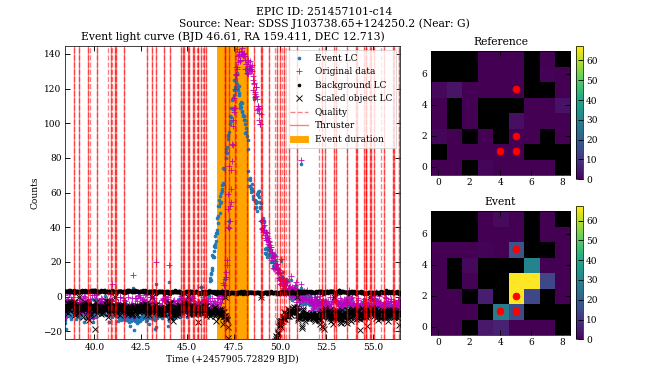

<IPython.core.display.Javascript object>


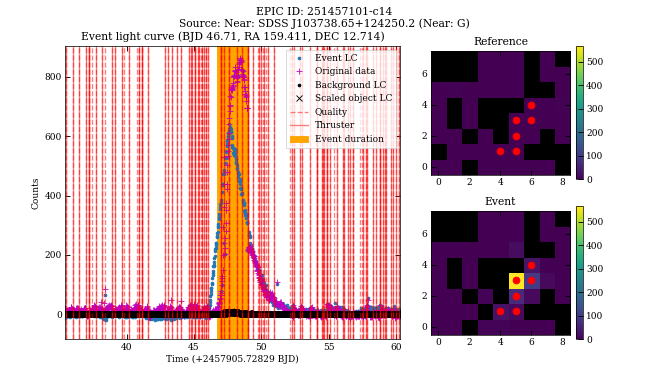

<IPython.core.display.Javascript object>


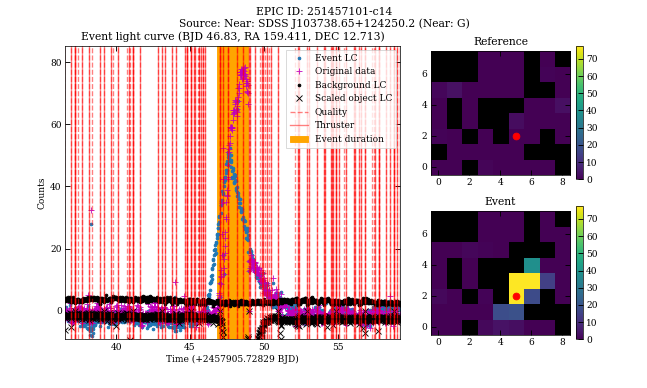

<IPython.core.display.Javascript object>


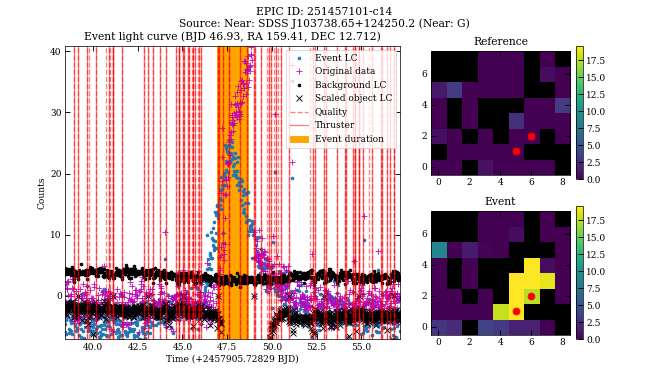

<IPython.core.display.Javascript object>


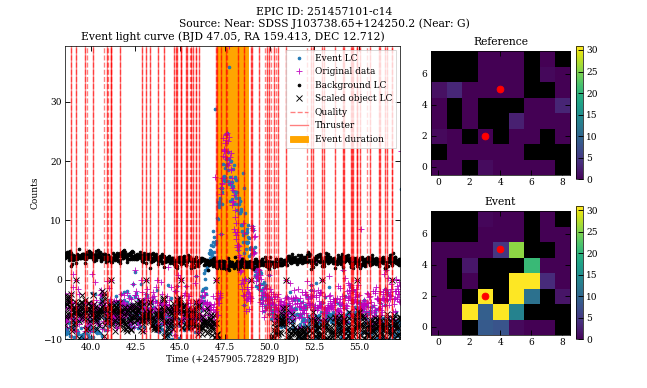

In [156]:
pixelfile = '/Users/ryanr/Documents/PhD/coding/Kepler/Data/ktwo251457101-c14_lpd-targ.fits.gz'#ktwo201357268-c01_lpd-targ.fits.gz'#ktwo201834023-c01_lpd-targ.fits.gz'#'/Users/ryanr/Documents/PhD/coding/Kepler/pipelines/goldenrod/data/ktwo212269339-c06_lpd-targ.fits.gz'
save = '/Users/ryanr/Documents/PhD/coding/Kepler/K2'

try:
    hdu = fits.open(pixelfile)
    dat = hdu[1].data
    datacube = fits.ImageHDU(hdu[1].data.field('FLUX')[:]).data#np.copy(testdata)#
    if datacube.shape[1] > 1 and datacube.shape[2] > 1:
        print('in')
        time = dat["TIME"] + 2454833.0
        Qual = hdu[1].data.field('QUALITY')
        thrusters = np.where((Qual == 1048576) | (Qual == 1089568) | (Qual == 1056768) | (Qual == 1064960) | (Qual == 1081376) | (Qual == 10240) | (Qual == 32768) | (Qual == 1097760))[0]
        quality = np.where(Qual != 0)[0]
        #calculate the reference frame
        Framemin = thrusters[3]+1
        # Apply object mask to data
        Mask = ThrustObjectMask(datacube,thrusters)

        Maskdata, ast = First_pass(np.copy(datacube),Qual,quality,thrusters,pixelfile)
        Maskdata = Maskdata*Mask
        Maskdata = Motion_correction(Maskdata,Mask,thrusters)*Mask

        # Make a mask for the object to use as a test to eliminate very bad pointings
        obj = np.ma.masked_invalid(Mask).mask
        objmed = np.nanmedian(datacube[thrusters+1]*obj,axis=(0))
        objstd = np.nanstd(datacube[thrusters+1]*obj,axis=(0))

        framemask = np.zeros(Maskdata.shape)

        limit = abs(np.nanmedian(Maskdata[Qual == 0], axis = (0))+3*(np.nanstd(Maskdata[Qual == 0], axis = (0))))
        framemask = ((Maskdata/limit) >= 1)
        framemask[:,np.where(Maskdata > 100000)[1],np.where(Maskdata > 100000)[2]] = 0

        # Identify if there is a sequence of consecutive or near consecutive frames that meet condtition 


        Eventmask_ref = (convolve(framemask,np.ones((1,3,3)),mode='constant', cval=0.0))*1
        Eventmask = np.copy(Eventmask_ref)
        Eventmask[~np.where((convolve(Eventmask_ref,np.ones((5,1,1)),mode='constant', cval=0.0) >= 4))[0]] = 0
        Eventmask[Qual!=0,:,:] = False
        Eventmask_ref[Qual!=0,:,:] = False

        Index = np.where(np.nansum(Eventmask*1, axis = (1,2))>0)[0]

        events = []
        eventtime = []
        while len(Index) > 1:

            similar = np.where(((Eventmask[Index[0]]*Eventmask_ref[Index[0]:]) == Eventmask[Index[0]]).all(axis = (1,2)))[0]+Index[0]

            if len((np.diff(similar)<5)) > 1:

                if len(np.where((np.diff(similar)<5) == False)[0]) > 0:
                    simEnd = np.where((np.diff(similar)<5) == False)[0][0] 
                else:
                    simEnd = -1
            else:
                simEnd = 0
            if (simEnd > 0):
                similar = similar[:simEnd]
            elif (simEnd == 0):
                similar = np.array([similar[0]])

            if len(similar) > 1:

                events.append(similar[0])
                temp = [similar[0]-1,similar[-1]+1]
                eventtime.append(temp)
                temp = []
            template = Eventmask[Index[0]]
            for number in similar:
                if (np.nansum(template*1-Eventmask[number]*1) == 0):
                    Index = np.delete(Index, np.where(Index == number)[0])

        events, eventtime, eventmask = EventSplitter(events,eventtime,Eventmask,framemask)  

        events = np.array(events)
        eventmask = np.array(eventmask)
        eventtime = np.array(eventtime)

        temp = []
        for i in range(len(events)):
            if len(np.where(datacube[eventtime[i][0]:eventtime[i][-1]]*eventmask[i] > 100000)[0]) == 0:
                temp.append(i)
        eventtime = eventtime[temp]
        events = events[temp]
        eventmask = eventmask[temp]

        if len(eventmask) > 0:
            middle = (convolve(eventmask,np.ones((1,3,3))) == np.nanmax(convolve(eventmask,np.ones((1,3,3))))) & (convolve(eventmask,np.ones((1,3,3)),mode='constant', cval=0.0) == np.nanmax(convolve(eventmask,np.ones((1,3,3)),mode='constant', cval=0.0)))
            eventmask = eventmask*middle


        # Eliminate events that do not meet thruster firing conditions
        events, eventtime, eventmask, asteroid, asttime, astmask = ThrusterElim(events,eventtime,eventmask,thrusters,quality,Qual,Maskdata)
        events = np.array(events)
        eventtime = np.array(eventtime)
        eventmask = np.array(eventmask)

        events, eventtime, eventmask = Match_events(events,eventtime,eventmask)



        # Create an array that saves the total area of mask and time. 
        # 1st col pixelfile, 2nd duration, 3rd col area, 4th col number of events, 5th 0 if in galaxy, 1 if outside
        # Define the coordinate system 
        funny_keywords = {'1CTYP4': 'CTYPE1',
                          '2CTYP4': 'CTYPE2',
                          '1CRPX4': 'CRPIX1',
                          '2CRPX4': 'CRPIX2',
                          '1CRVL4': 'CRVAL1',
                          '2CRVL4': 'CRVAL2',
                          '1CUNI4': 'CUNIT1',
                          '2CUNI4': 'CUNIT2',
                          '1CDLT4': 'CDELT1',
                          '2CDLT4': 'CDELT2',
                          '11PC4': 'PC1_1',
                          '12PC4': 'PC1_2',
                          '21PC4': 'PC2_1',
                          '22PC4': 'PC2_2'}
        mywcs = {}
        for oldkey, newkey in funny_keywords.items():
            mywcs[newkey] = hdu[1].header[oldkey] 
        mywcs = WCS(mywcs)

        # Save thrusts and quality flags and time 
        Fieldprop = {}
        Fieldprop['File'] = pixelfile
        Fieldprop['Thruster'] = len(thrusters)
        Fieldprop['Quality'] = len(quality)-len(thrusters)
        Fieldprop['Duration'] = len(time)
        Fieldprop['Gal_lat'] = Get_gal_lat(mywcs,datacube)

        # Find all spatially seperate objects in the event mask.
        Objmasks = Identify_masks(obj)
        if len(events) > 0:
            Source, SourceType = Database_event_check(Maskdata,eventtime,eventmask,mywcs)
            ObjName, ObjType = Database_check_mask(datacube,thrusters,Objmasks,mywcs)
            Near = Near_which_mask(eventmask,Objmasks)

            for ind in np.where(Near != -1)[0]:
                Source[ind] = 'Near: ' + ObjName[Near[ind]]
                SourceType[ind] = 'Near: ' + ObjType[Near[ind]]


            # Print figures
            K2TranPixFig(events,eventtime,eventmask,Maskdata,time,Eventmask,mywcs,save,pixelfile,quality,thrusters,Framemin,datacube,Source,SourceType)
            #K2TranPixGif2(events,eventtime,eventmask,Maskdata,mywcs,save,pixelfile,Source,SourceType)


except (OSError):
    pass

In [22]:
np.isfinite(np.inf)

False

In [72]:
os.system(ffmpegcall)

0

In [66]:
Objmasks

[array([[ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]]),
 array([[0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0]]),
 array([[0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 1, 0, 0, 0, 0],
        [0, 1, 0, 1, 1, 0, 0, 0, 0],
        [0, 1, 0, 1, 1, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 1, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0],
 

<IPython.core.display.Javascript object>


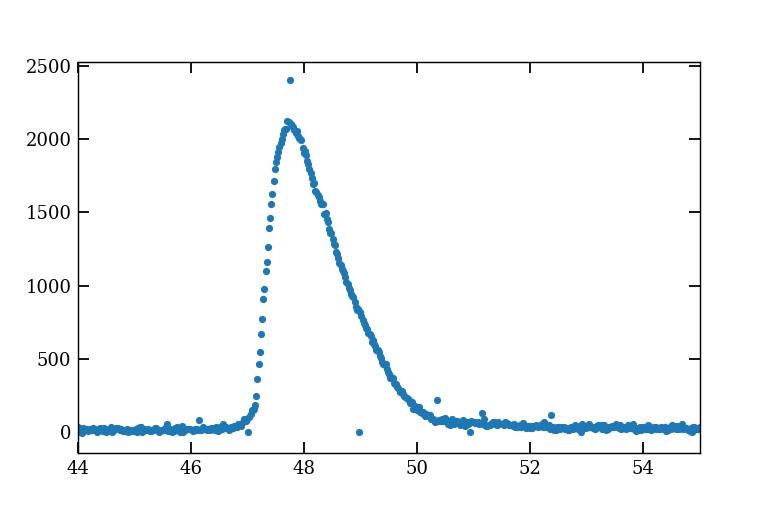

(44, 55)

In [74]:
plt.figure()
plt.plot(time-time[0],np.nansum(datacube*(Objmasks[2]+eventmask[1]),axis=(1,2)),'.')
plt.xlim(44,55)

In [137]:
def K2TranPixCompFig(Events,Eventtime,Eventmask,Data,Time,Frames,wcs,Save,File,Quality,Thrusters,Framemin,Datacube,Source,SourceType):
    position = np.where(Eventmask)
    maxcolor = np.nanmax(Datacube[Eventtime[0]:Eventtime[-1]]*(Eventmask==1))
    Mid = np.where(Datacube[Eventtime[0]:Eventtime[-1]]*(Eventmask==1) == maxcolor)
    Coord = pix2coord(Mid[2],Mid[1],wcs)
    print(Coo)
    # Generate a light curve from the transient masks
    LC = np.nansum(Datacube*Eventmask, axis = (1,2))
    BG = Datacube*~Frames[Events]
    BG[BG <= 0] =np.nan
    BGLC = np.nanmedian(BG, axis = (1,2))


    fig = plt.figure(figsize=(10,6))
    # set up subplot grid
    gridspec.GridSpec(2,3)
    plt.suptitle('EPIC ID: ' + File.split('ktwo')[-1].split('_')[0] + '\nSource: '+ Source + ' (' + SourceType + ')')
    # large subplot
    plt.subplot2grid((2,3), (0,0), colspan=2, rowspan=2)
    plt.title('Event light curve (BJD '+str(round(Time[Eventtime[0]]-Time[0],2))+', RA '+str(round(Coord[0],3))+', DEC '+str(round(Coord[1],3))+')')
    plt.xlabel('Time (+'+str(Time[0])+' BJD)')
    plt.ylabel('Counts')
    plt.plot(Time - Time[0], LC,'.', label = 'Event LC')
    plt.plot(Time - Time[0], BGLC,'k.', label = 'Background LC')
    plt.minorticks_on()

    if Eventtime[-1] < len(Time):
        plt.axvspan(Time[Eventtime[0]]-Time[0],Time[Eventtime[-1]]-Time[0], color = 'orange', label = 'Event duration')
    else:
        plt.axvspan(Time[Eventtime[0]]-Time[0],Time[-1]-Time[0], color = 'orange', label = 'Event duration')
    plt.axvline(Time[Quality[0]]-Time[0],color = 'red', linestyle='dashed',label = 'Quality', alpha = 0.5)
    for j in range(Quality.shape[0]-1):
        j = j+1 
        plt.axvline(Time[Quality[j]]-Time[0], linestyle='dashed', color = 'red', alpha = 0.5)
    # plot Thurster firings 
    plt.axvline(Time[Thrusters[0]]-Time[0],color = 'red',label = 'Thruster', alpha = 0.5)
    for j in range(Thrusters.shape[0]-1):
        j = j+1 
        plt.axvline(Time[Thrusters[j]]-Time[0],color = 'red', alpha = 0.5)
    xmin = Time[Eventtime[0]]-Time[0]-(Eventtime[-1]-Eventtime[0])/10
    xmax = Time[Eventtime[-1]]-Time[0]+(Eventtime[-1]-Eventtime[0])/10
    if xmin < 0:
        xmin = 0
    if xmax > Time[-1] - Time[0]:
        xmax = Time[-1] - Time[0]
    plt.xlim(xmin,xmax) # originally 48 for some reason
    plt.ylim(np.nanmedian(LC)-np.nanstd(LC),np.nanmax(LC[Eventtime[0]:Eventtime[-1]])+0.1*np.nanmax(LC[Eventtime[0]:Eventtime[-1]]))
    plt.legend(loc = 1)
    # small subplot 1 Reference image plot
    plt.subplot2grid((2,3), (0,2))
    plt.title('Reference')
    plt.imshow(Datacube[Framemin,:,:], origin='lower',vmin=0,vmax = maxcolor)
    current_cmap = plt.cm.get_cmap()
    current_cmap.set_bad(color='black')
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.plot(position[1],position[0],'r.',ms = 15)
    # small subplot 2 Image of event
    plt.subplot2grid((2,3), (1,2))
    plt.title('Event')
    plt.imshow(Datacube[np.where(Datacube*Eventmask==np.nanmax(Datacube[Eventtime[0]:Eventtime[-1]]*Eventmask))[0][0],:,:], origin='lower',vmin=0,vmax = maxcolor)
    current_cmap = plt.cm.get_cmap()
    current_cmap.set_bad(color='black')
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.plot(position[1],position[0],'r.',ms = 15),plt.savefig(Save+'-4day.pdf')


[ 159.41331559   12.71558642]


<IPython.core.display.Javascript object>


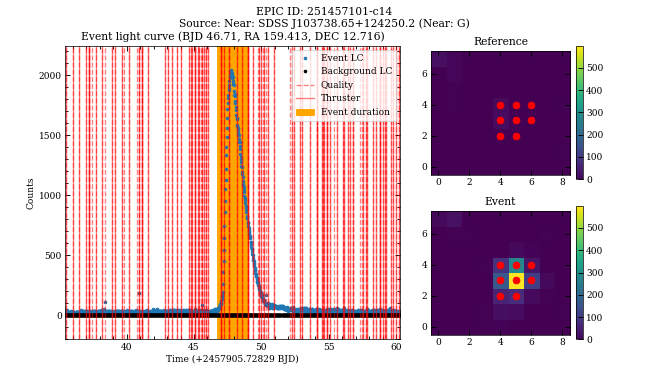

In [138]:
K2TranPixCompFig(events[1],eventtime[1],Compmask,Maskdata,time,Eventmask,mywcs,save,pixelfile,quality,thrusters,Framemin,datacube,Source[1],SourceType[1])       

In [153]:
def Database_event_check(Data,Eventtime,Eventmask,WCS):
    # Checks Ned and Simbad to check the event position against known objects.
    Objects = []
    Objtype = []
    for I in range(len(Eventtime)):
        maxcolor = np.nanmax(Data[Eventtime[I][0]:Eventtime[I][-1]]*(Eventmask[I]==1))

        Mid = np.where(Data[Eventtime[I][0]:Eventtime[I][-1]]*(Eventmask[I]==1) == maxcolor)

        Coord = pix2coord(Mid[1],Mid[0],WCS)

        c = coordinates.SkyCoord(ra=Coord[0], dec=Coord[1],unit=(u.deg, u.deg), frame='icrs')

        Ob = 'Unknown'
        objtype = 'Unknown'
        try:
            result_table = Ned.query_region(c, radius = 6*u.arcsec, equinox='J2000')
            Ob = np.asarray(result_table['Object Name'])[0].decode("utf-8") 
            objtype = result_table['Type'][0].decode("utf-8") 

            if '*' in objtype:
                objtype = objtype.replace('*','Star')
            if '!' in objtype:
                objtype = objtype.replace('!','G') # Galactic sources
                
        except (RemoteServiceError,ExpatError) as e:
            result_table = Simbad.query_region(c,radius = 6*u.arcsec)
            try:
                if len(result_table.colnames) > 0:
                    Ob = np.asarray(result_table['MAIN_ID'])[0].decode("utf-8") 
                    objtype = 'Simbad'
            except (AttributeError,ExpatError) as e:
                pass
        Objects.append(Ob)
        Objtype.append(objtype)
        
    return Objects, Objtype

In [154]:
Database_event_check(Maskdata,eventtime,eventmask,mywcs)

(['SDSS J103742.08+124755.0',
  'Unknown',
  'Unknown',
  'SDSS J103742.70+124754.5',
  'Unknown'],
 ['G', 'Unknown', 'Unknown', 'Star', 'Unknown'])

In [152]:
ExpatError

xml.parsers.expat.ExpatError

In [120]:
6*u.arcsec

<Quantity 6.0 arcsec>

<IPython.core.display.Javascript object>


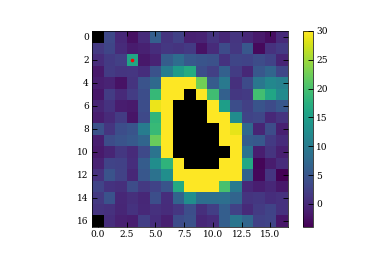

In [73]:
plt.figure()
plt.imshow(Maskdata[eventtime[1][0]],vmax =30)#,origin ='lower')
plt.plot(3,2,'r.')
plt.colorbar()

In [66]:
pix2coord(3,2,mywcs)

array([ 179.03982978,   -1.58925769])

In [75]:
maxcolor = np.nanmax(Maskdata[eventtime[1][0]:eventtime[1][-1]]*(eventmask[1]==1))
Mid = np.where(Maskdata[eventtime[1][0]:eventtime[1][-1]]*(eventmask[1]==1) == maxcolor)
Mid

(array([16]), array([2]), array([3]))

(array([80]), array([2]), array([5]))
[ 159.41059052   12.71261426]
(array([75]), array([3]), array([5]))
[ 159.41074985   12.71370838]
(array([87]), array([2]), array([5]))
[ 159.41059052   12.71261426]
(array([81]), array([1]), array([5]))
[ 159.41043119   12.71152015]
(array([34]), array([2]), array([3]))
[ 159.41283755   12.71230408]


(['SDSS J103738.65+124250.2',
  'SDSS J103738.65+124250.2',
  'SDSS J103738.65+124250.2',
  'Unknown',
  'Unknown'],
 ['Galaxy', 'Galaxy', 'Galaxy', 'Unknown', 'Unknown'])

(['Unknown',
  'Unknown',
  'SDSS J103738.65+124250.2',
  'SDSS J103739.46+124257.8',
  'Unknown'],
 ['Unknown', 'Unknown', 'G', 'G', 'Unknown'])

In [89]:
if len(thrusters[(thrusters >= eventtime[0][0]) & (thrusters <= eventtime[0][-1])]) >= 3:
    print('long')
else:
    print('short')

short


In [84]:
thrusters > eventtime[0]

array([ 105,  165,  189,  285,  309,  381,  405,  453,  477,  478,  501,
        525,  561,  573,  585,  609,  621,  645,  657,  669,  670,  693,
        717,  741,  753,  765,  789,  825,  837,  861,  885,  897,  921,
        933,  957,  969,  981, 1005, 1017, 1041, 1053, 1065, 1077, 1101,
       1113, 1137, 1149, 1173, 1197, 1209, 1233, 1245, 1269, 1293, 1317,
       1341, 1365, 1389, 1413, 1437, 1449, 1473, 1497, 1533, 1557, 1581,
       1617, 1629, 1665, 1701, 1725, 1761, 1773, 1821, 1845, 1893, 1941,
       2133, 2181, 2277, 2313, 2349, 2361, 2373, 2374, 2397, 2409, 2421,
       2433, 2445, 2457, 2469, 2470, 2481, 2493, 2505, 2529, 2541, 2553,
       2565, 2577, 2601, 2613, 2625, 2649, 2661, 2673, 2685, 2709, 2721,
       2733, 2745, 2757, 2769, 2781, 2793, 2817, 2829, 2841, 2853, 2865,
       2877, 2889, 2901, 2913, 2925, 2937, 2949, 2961, 2973, 2985, 2997,
       3009, 3021, 3033, 3045, 3057, 3069, 3081, 3105, 3117, 3129, 3141,
       3142, 3165, 3177, 3189, 3201, 3212, 3213, 32

In [85]:
eventtime

array([], dtype=float64)

In [238]:
a = 'a, b'
if 'a' not in a:
    print('in')

In [ ]:
plt.figure()
plt.imshow(near_mask-2*obj,origin='lower')
plt.plot(np.where(isnear==1)[2],np.where(isnear==1)[1],'r.')
plt.colorbar()

In [ ]:
cross = np.ones((3,3))
cross[[0,0,2,2],[0,2,0,2]] = 0

In [ ]:
test = ((convolve(obj*1,cross,mode='constant', cval=0.0)))*1

In [100]:
objmasks[Where_which_mask(eventmask,objmasks)]

TypeError: only integer scalar arrays can be converted to a scalar index

<IPython.core.display.Javascript object>


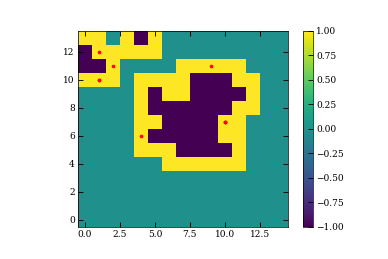

In [88]:
plt.figure()
plt.imshow(near_mask-2*obj,origin='lower')
plt.plot(np.where(isnear==1)[2],np.where(isnear==1)[1],'r.')
plt.colorbar()

In [72]:
Database_check_mask(datacube,thrusters,objmasks,mywcs)

([b'SDSS J111145.58+055958.8', 'None', 'None'], ['Star', 'None', 'None'])

In [ ]:
test = ((convolve(mask1*1,np.ones((3,3)),mode='constant', cval=0.0)) > 0)*1.0
plt.figure()
plt.imshow(test*objsub,origin='lower')
plt.colorbar()

In [ ]:
result_table = Simbad.query_region(c,radius = 4*u.arcsec)
Ob = []
try:
    if len(result_table.colnames) > 0:
        Ob = np.asarray(result_table['MAIN_ID'])[0]
except AttributeError:
    print('first except')
    try:
        result_table = Ned.query_region(c, radius=4 * u.arcsec, equinox='J2000')
    except RemoteServiceError:
        print('second except')
        pass
    

In [ ]:
Ob = np.asarray(result_table['MAIN_ID'])[0]

In [ ]:
Ob

In [ ]:
np.asarray(result_table['MAIN_ID'])

In [ ]:


try:
    result_table = Ned.query_region(c, radius=4 * u.arcmin, equinox='J2000')
except RemoteServiceError:
    pass

In [ ]:
result_table.colnames

In [ ]:
maxes = []
for i in range(len(events)):
    eventlc = np.nansum(Maskdata*eventmask[i],axis=(1,2))
    maxes.append(Smoothmax(eventtime[i],eventlc,Qual))

In [ ]:
eventtime[15]

In [ ]:
eventtime[15]

In [ ]:
def Match_events(Events,Eventtime,Eventmask,Data):
    i = 0
    while i < len(Events):
        coincident = (((Eventtime[:,0] >= Eventtime[i,0]-3) & (Eventtime[:,0] <= Eventtime[i,0]+3)) | ((Eventtime[:,1] >= Eventtime[i,1]-3) & (Eventtime[:,1] <= Eventtime[i,1]+3)))       
        if sum(coincident*1) > 1:
            newmask = (np.nansum(Eventmask[coincident],axis = (0)) > 0)*1 

            Events = np.delete(Events,np.where(coincident)[0][1:])
            Eventtime = np.delete(Eventtime,np.where(coincident)[0][1:], axis = (0))
            Eventmask = np.delete(Eventmask,np.where(coincident)[0][1:], axis = (0))
            Eventmask[i] = newmask

        i +=1
    maxes = []
    for i in range(len(Events)):
        eventlc = np.nansum(Maskdata*Eventmask[i],axis=(1,2))
        maxes.append(Smoothmax(Eventtime[i],eventlc,Qual)[0])
    i = 0
    maxes = np.array(maxes)

    while i < len(Events):
        coincident = (maxes >= maxes[i]-4) & (maxes <= maxes[i]+4)

        if sum(coincident*1) > 1:
            newmask = (np.nansum(Eventmask[coincident],axis = (0)) > 0)*1 

            Events = np.delete(Events,np.where(coincident)[0][1:])
            Eventtime = np.delete(Eventtime,np.where(coincident)[0][1:], axis = (0))
            Eventmask = np.delete(Eventmask,np.where(coincident)[0][1:], axis = (0))
            Eventmask[i] = newmask
            maxes = np.delete(maxes,np.where(coincident)[0][1:])
        i +=1
    return Events, Eventtime,Eventmask

In [ ]:
Match_events(events,eventtime,eventmask,Maskdata)

In [ ]:
thing = abs(np.nanmedian(Maskdata, axis = (0))+3*(np.nanstd(Maskdata, axis = (0))))
Kp = -2.5*np.log10(thing) + 25.47
fig = plt.figure()
plt.imshow(Kp,origin='lower')
current_cmap = plt.cm.get_cmap()
current_cmap.set_bad(color='black')
cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.ax.set_ylabel('$K_p$')
plt.minorticks_on()
fig.set_size_inches(fig_width,fig_width)
#plt.tight_layout()
#plt.savefig('/Users/ryanr/Documents/PhD/coding/Kepler/Paper figs/maglim_paper_example.pdf', dpi = 1000,bbox_inches = 'tight');



In [ ]:
testlc = datacube[:,4,3]
plt.figure()
plt.plot(testlc,'.')
for i in thrusters:
    plt.axvline(i,color='r')

In [ ]:
from scipy.optimize import curve_fit

In [ ]:
def polyfit_with_fixed_points(d, x, y, xf, yf) :
    mat = np.empty((d + 1 + len(xf),) * 2)
    vec = np.empty((d + 1 + len(xf),))
    x_n = x**np.arange(2 * d + 1)[:, None]
    yx_n = np.sum(x_n[:d + 1] * y, axis=1)
    x_n = np.sum(x_n, axis=1)
    idx = np.arange(d + 1) + np.arange(d + 1)[:, None]
    mat[:d + 1, :d + 1] = np.take(x_n, idx)
    xf_n = xf**np.arange(d + 1)[:, None]
    mat[:d + 1, d + 1:] = xf_n / 2
    mat[d + 1:, :d + 1] = xf_n.T
    mat[d + 1:, d + 1:] = 0
    vec[:d + 1] = yx_n
    vec[d + 1:] = yf
    params = np.linalg.solve(mat, vec)
    return params[:d + 1]

In [ ]:
xf=np.array((x[0],x[-1]))
yf=np.array((thing[0],thing[-1]))
a = polyfit_with_fixed_points(3,x,thing,xf,yf)

In [ ]:
xf=np.array((x[0],x[-1]))
yf=np.array((thing[0],thing[-1]))
a = polyfit_with_fixed_points(3,x,thing,xf,yf)
poly = np.polynomial.Polynomial(a)
plt.figure()
plt.plot(poly(x))

In [ ]:
def func(x, a, b, c):
    return a * np.arctan(b * x) + c

In [ ]:
pot = curve_fit(func,x,thing)

In [ ]:
def poly3(x, a, b, c):
    return a*(x+b)**3 + c

In [ ]:
pot = curve_fit(poly3,x,thing)

In [ ]:
eventmask[-1]

In [ ]:
x1 = 3875
x2 = 3884

z = np.arange(0,len(datacube))
ind = np.where(~np.isnan(datacube[thrusters+2,5,4]))[0]
Splinef = interp1d(z[thrusters[ind]+2],datacube[thrusters[ind]+2,5,4], kind='linear',fill_value='extrapolate' )#np.interp(z,z[thrusters+1],datacube[thrusters+1,4,3])
Spline = Splinef(z)
Spline[np.isnan(Spline)] = 0

thing = np.copy(datacube[x1:x2,5,4]) - Spline[x1:x2]
temp = np.copy(thing)  
#thing[20:25] += 1000
x = np.arange(0,len(thing))
limit = np.nanmedian(abs(np.diff(np.diff(thing))))+2.5*np.nanstd(abs(np.diff(np.diff(thing)))) 
yo = np.where(abs(np.diff(np.diff(thing)))>limit)[0]+1
print(yo)


if len(yo)/2 == int(len(yo)/2):
    i = 0
    while i + 1 < len(yo):
        print('even')
        yoarr = np.arange(yo[i],yo[i+1])
        temp[yoarr] = np.nan
        yo = np.delete(yo,[0,1])
else:
    i = 0
    while i + 2 < len(yo):
        yoarr = np.arange(yo[i],yo[i+1])
        temp[yoarr] = np.nan
        yo = np.delete(yo,[0,1])
if len(yo) == 1:
    print('in')
    temp[yo] = np.nan

xx = x[~np.isnan(temp)]
p3 = np.poly1d(np.polyfit(xx, thing[xx], 3))

In [ ]:
plt.figure()
plt.plot(x,thing+Spline[x1:x2],'.')
#plt.plot(pot[0]*(x+pot[1])**3+pot[2])
plt.plot(x,p3(x+2)+Spline[x1:x2],'-')
plt.plot(Spline[x1:x2])
#plt.plot(x,pot(x),'.')

plt.figure()

#plt.plot(thing-(pot[0]*(x+pot[1])**3+pot[2]),'.')
plt.plot(thing-p3(x+2),'g-')
#plt.plot(thing-poly(x))



In [ ]:
np.where(eventmask[-1]==1)

In [ ]:
eventtime[-1]

In [ ]:
plt.figure()
plt.plot(datacube[:,12,1])
plt.xlim(3787,3792)

In [ ]:
plt.figure()
plt.plot(Maskdata[:,11,5])
plt.xlim(3880,3893)

In [ ]:
eventtime[-1]

In [ ]:

from scipy.interpolate import interp1d

In [ ]:
AvSplinepoints = np.zeros(len(thrusters))
AvSplineind = np.zeros(len(thrusters))
for i in range(len(thrusters)):
    AvSplinepoints[i] = np.nanmin(datacube[thrusters[i]+1:thrusters[i]+3,X,Y])
    if ~np.isnan(AvSplinepoints[i]):
        AvSplineind[i] = np.where(AvSplinepoints[i] == datacube[thrusters[i]+1:thrusters[i]+3,X,Y])[0]+thrusters[i]+1

In [ ]:
AvSplineind

In [ ]:
datacube[thrusters[124]+1:thrusters[124]+3,X,Y]

In [13]:
X = 2
Y = 3
test2 = []
test2 = np.copy(datacube[:,X,Y])
fit = np.zeros(len(datacube))
z = np.arange(0,len(datacube))


AvSplinepoints = np.zeros(len(thrusters))
AvSplineind = np.zeros(len(thrusters))
for i in range(len(thrusters)):
    ErrorCheck = np.copy(datacube[thrusters[i]+1:thrusters[i]+3,X,Y])
    ErrorCheck[ErrorCheck >= np.nanmedian(ErrorCheck)+3*np.nanstd(ErrorCheck)] = np.nan
    AvSplinepoints[i] = np.nanmin(ErrorCheck)
    if ~np.isnan(AvSplinepoints[i]):
        AvSplineind[i] = np.where(AvSplinepoints[i] == datacube[thrusters[i]+1:thrusters[i]+3,X,Y])[0]+thrusters[i]+1
    else:
        AvSplineind[i] = np.nan
ind = np.where(~np.isnan(AvSplineind))
Splinef = interp1d(AvSplineind[ind],AvSplinepoints[ind], kind='linear',fill_value='extrapolate' )#np.interp(z,z[thrusters+1],datacube[thrusters+1,4,3])
Spline = Splinef(z)
Spline[np.isnan(Spline)] = 0
for i in range(len(thrusters)-1):

    if abs(thrusters[i]-thrusters[i+1]) > 2:
        thing = np.copy(datacube[thrusters[i]+2:thrusters[i+1],X,Y]) -  Spline[thrusters[i]+2:thrusters[i+1]]
        temp = np.copy(thing)
        x = np.arange(0,len(thing))
        limit =np.nanmedian(np.diff(np.diff(thing)))+2.5*np.nanstd(np.diff(np.diff(thing)))
        yo = np.where(np.diff(np.diff(thing))>limit)[0]+1
        if thrusters[i] ==309:
            print(yo)
            print(thrusters[i]+2,thrusters[i+1])
        if len(yo)/2 == int(len(yo)/2):
            z = 0
            while z + 1 < len(yo):
                yoarr = np.arange(yo[z],yo[z+1])
                temp[yoarr] = np.nan
                yo = np.delete(yo,[0,1])
        else:
            z = 0
            while z + 2 < len(yo):
                yoarr = np.arange(yo[z],yo[z+1])
                temp[yoarr] = np.nan
                yo = np.delete(yo,[0,1])
        if len(yo) == 1:
            temp[yo] = np.nan
        
        xx = np.where(~np.isnan(temp))[0]
        if len(xx)/len(x) > 0.5:
            p3 = np.poly1d(np.polyfit(xx, thing[xx], 3))
            test2[x+thrusters[i]+2] = datacube[thrusters[i]+2:thrusters[i+1],X,Y] - p3(x)# + Spline[thrusters[i]:thrusters[i+1]-1]) #+ p3(x[0]) #
            fit[x+thrusters[i]+2] = p3(x) + Spline[thrusters[i]+2:thrusters[i+1]]
        

[12]
311 381


<IPython.core.display.Javascript object>


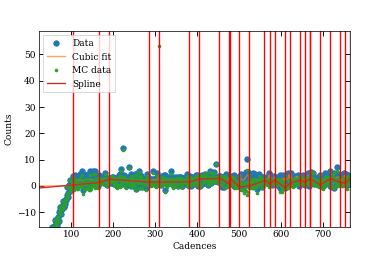

In [14]:
plt.figure()
plt.plot(datacube[:,X,Y],'o',label='Data')
plt.plot(fit,'-',alpha=0.7,label='Cubic fit')
plt.plot(test2,'.',label='MC data')

plt.plot(Spline,'-',label='Spline')
#plt.plot(test[:,X,Y],'.-',label='MCF data')
#plt.plot(testspline[],'-',label='test Spline')

for i in thrusters:
    plt.axvline(i,color='red')
plt.ylabel('Counts')
plt.xlabel('Cadences')
#plt.xlim(3800,3900)
#plt.ylim(-5,10)
plt.legend();
#plt.savefig(save+'MC_example.pdf')

In [91]:
eventtime[-2]

array([2153, 2174])

In [12]:
np.nanmedian(datacube[309:380,X,Y])+3*np.nanstd(datacube[309:380,X,Y])

20.933215618133545

6.2421012

In [50]:
def Motion_correction(Data,Mask,Thrusters):
    Corrected = np.zeros((Data.shape[0],Data.shape[1],Data.shape[2]))
    
    fit = np.zeros(len(Data))
    X = np.where(Mask == 1)[0]
    Y = np.where(Mask == 1)[1]
    for j in range(len(X)):
        temp = np.copy(Data[:,X[j],Y[j]])
        #temp[temp==0] = np.nan
        zz = np.arange(0,len(Data))
        AvSplinepoints = np.zeros(len(Thrusters))
        AvSplineind = np.zeros(len(Thrusters))
        for i in range(len(Thrusters)):
            AvSplinepoints[i] = np.nanmin(Data[Thrusters[i]+1:Thrusters[i]+3,X[j],Y[j]])
            if ~np.isnan(AvSplinepoints[i]):
                if len(np.where(AvSplinepoints[i] == Data[Thrusters[i]+1:Thrusters[i]+3,X[j],Y[j]])[0]+Thrusters[i]+1) > 1:
                    AvSplineind[i] = np.where(AvSplinepoints[i] == Data[Thrusters[i]+1:Thrusters[i]+3,X[j],Y[j]])[0][0]+Thrusters[i]+1
                else:
                    AvSplineind[i] = np.where(AvSplinepoints[i] == Data[Thrusters[i]+1:Thrusters[i]+3,X[j],Y[j]])[0]+Thrusters[i]+1 
            else:
                AvSplineind[i] = np.nan
        ind = np.where(~np.isnan(AvSplineind))
        if len(ind[0]) > 1:
            Splinef = interp1d(AvSplineind[ind],AvSplinepoints[ind], kind='linear',fill_value='extrapolate' )
            Spline = Splinef(zz)
            Spline[np.isnan(Spline)] = 0
            for i in range(len(Thrusters)-1):

                if abs(Thrusters[i]-Thrusters[i+1]) > 5:
                    try:
                        Section = np.copy(Data[Thrusters[i]+2:Thrusters[i+1],X[j],Y[j]]) - Spline[thrusters[i]+2:thrusters[i+1]]
                        temp2 = np.copy(Section)
                        x = np.arange(0,len(Section))
                        limit =np.nanmedian(np.diff(np.diff(Section)))+2.5*np.nanstd(np.diff(np.diff(Section)))
                        yo = np.where(np.diff(np.diff(Section))>limit)[0]+1
                        if len(yo)/2 == int(len(yo)/2):
                            z = 0
                            while z + 1 < len(yo):
                                yoarr = np.arange(yo[z],yo[z+1])
                                temp2[yoarr] = np.nan
                                yo = np.delete(yo,[0,1])
                        else:
                            z = 0
                            while z + 2 < len(yo):
                                yoarr = np.arange(yo[z],yo[z+1])
                                temp2[yoarr] = np.nan
                                yo = np.delete(yo,[0,1])
                        if len(yo) == 1:
                            temp[yo] = np.nan
                        xx = np.where(~np.isnan(temp2))[0]
                        if len(xx) > 3:
                            p3 = np.poly1d(np.polyfit(xx, Section[xx], 3))
                            temp[x+Thrusters[i]+2] = np.copy(Data[Thrusters[i]+2:Thrusters[i+1],X[j],Y[j]]) - p3(x) #+ Spline[thrusters[i]+2:thrusters[i+1]]
                            fit[x+Thrusters[i]+2] = p3(x)
                        #else:
                         #   print(i)
                    except RuntimeError:
                        pass
        Corrected[:,X[j],Y[j]] = temp
        
                    
    return Corrected

In [77]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

In [25]:
def Motion_correction(Data,Mask,Thrusters):
    Corrected = np.zeros((Data.shape[0],Data.shape[1],Data.shape[2]))
    
    fit = np.zeros(len(Data))
    X = np.where(Mask == 1)[0]
    Y = np.where(Mask == 1)[1]
    for j in range(len(X)):
        temp = np.copy(Data[:,X[j],Y[j]])
        #temp[temp==0] = np.nan
        zz = np.arange(0,len(datacube))
        AvSplinepoints = np.zeros(len(Thrusters))
        AvSplineind = np.zeros(len(Thrusters))
        for i in range(len(Thrusters)):
            AvSplinepoints[i] = np.nanmin(Data[Thrusters[i]+1:Thrusters[i]+3,X[j],Y[j]])
            if ~np.isnan(AvSplinepoints[i]):
                AvSplineind[i] = np.where(AvSplinepoints[i] == Data[Thrusters[i]+1:Thrusters[i]+3,X[j],Y[j]])[0]+Thrusters[i]+1
            else:
                AvSplineind[i] = np.nan
            
        ind = np.where(~np.isnan(AvSplineind))
        #AvSplinepoints[ind] = smooth(AvSplinepoints,5)
        Splinef = interp1d(AvSplineind[ind],AvSplinepoints[ind], kind='linear',fill_value='extrapolate' )
        Spline = Splinef(zz)
        Spline[np.isnan(Spline)] = 0
        for i in range(len(Thrusters)-1):

            if abs(Thrusters[i]-Thrusters[i+1]) > 5:
                try:
                    Section = np.copy(Data[Thrusters[i]+2:Thrusters[i+1],X[j],Y[j]]) - Spline[thrusters[i]+2:thrusters[i+1]]
                    temp2 = np.copy(Section)
                    x = np.arange(0,len(Section))
                    limit =np.nanmedian(np.diff(np.diff(Section)))+2.5*np.nanstd(np.diff(np.diff(Section)))
                    yo = np.where(np.diff(np.diff(Section))>limit)[0]+1
                    if len(yo)/2 == int(len(yo)/2):
                        z = 0
                        while z + 1 < len(yo):
                            yoarr = np.arange(yo[z],yo[z+1])
                            temp2[yoarr] = np.nan
                            yo = np.delete(yo,[0,1])
                    else:
                        z = 0
                        while z + 2 < len(yo):
                            yoarr = np.arange(yo[z],yo[z+1])
                            temp2[yoarr] = np.nan
                            yo = np.delete(yo,[0,1])
                    if len(yo) == 1:
                        temp[yo] = np.nan
                    xx = np.where(~np.isnan(temp2))[0]
                    if len(xx) > 3:
                        p3 = np.poly1d(np.polyfit(xx, Section[xx], 3))
                        temp[x+Thrusters[i]+2] = np.copy(Data[Thrusters[i]+2:Thrusters[i+1],X[j],Y[j]]) - p3(x) #+ Spline[thrusters[i]+2:thrusters[i+1]]
                        fit[x+Thrusters[i]+2] = p3(x)
                    #else:
                     #   print(i)
                except RuntimeError:
                    pass
        Corrected[:,X[j],Y[j]] = temp
        
                    
    return Corrected
            

In [51]:
test = Motion_correction(datacube,Mask,thrusters)

In [58]:
a = np.where(np.zeros((3))==1)
len(a[0])

0

## Asteroid check function

In [ ]:
from astropy.table import Table
import urllib2


def url_path(ra, dec, epoch, sr):
    url = "http://vo.imcce.fr/webservices/skybot/skybotconesearch_query.php?EPOCH={}&RA={}&DEC={}&SR={}".format(epoch, ra,dec, sr)

    return url


def read_table(urlpath):
    try:
        t = Table.read(urlpath)
        return t[0]['name'], t[0]['num']
    except ValueError:
        return "NOTFOUND", "NOTFOUND"
    except urllib2.URLError:
        return read_table_if_time_out_error(urlpath)

    # except urlib.error.URLError:
    #     return "SOME_OTHER_ERROR", "SOME_OTHER_ERROR"


def read_table_if_time_out_error(urlpath):
    try:
        response = urllib2.urlopen(urlpath, timeout=5)
        html = response.read()
        with open('votable_test.txt', 'w') as f:
            f.write(html)
        t = Table.read('votable_test.txt')
        return t[0]['name'], t[0]['num']
    except urllib2.URLError, e:
        print(e)
        return "NO_URL_FOUND", "NO_URL_FOUND"



def check_catalog(ra, dec, epoch, searchRadius):
    url = url_path(ra, dec, epoch, searchRadius)
    catalogName, catalogNum = read_table(url)

    return catalogName, catalogNum


def output_file(inputFilename, outputFilename, sr):
    infoList = np.genfromtxt(inputFilename, skip_header=1, dtype=None)
    nameList = []

    f = open(outputFilename, 'w')
    f.write("# ID,RA,DEC,EPOCH,DATABASE_NAME,DATABASE_NUM\n")

    for info in infoList:
        title, ra, dec, epoch = str(info).strip("'").split(',')
        url = url_path(ra, dec, epoch, sr)
        outName, outNum = read_table(url)
        nameList.append(outName)

        f.write(str(info.decode("utf-8")) + "," + str(outName) + "," + str(outNum) + "\n")
    f.close()

    return nameList


print(output_file('testInput.csv', 'testOutput.csv', 0.003))

## Look to see how the detection limit has improved

In [ ]:
origlim = abs(np.nanmedian(Maskdata, axis = (0))+3*(np.nanstd(Maskdata, axis = (0))))
origkp = -2.5*np.log10(origlim) + 25.47
testlim = abs(np.nanmedian(test, axis = (0))+3*(np.nanstd(test, axis = (0))))
testkp = -2.5*np.log10(testlim) + 25.47

In [ ]:
plt.figure()
plt.title('Count difference in the limit (smaller better)')
plt.imshow(testlim-origlim,origin='lower')
plt.colorbar()
plt.savefig(save+'MC_difference.pdf')

plt.figure()
plt.title('Mag difference in limit')
plt.imshow(testkp-origkp,origin='lower',vmin=0)
plt.colorbar()
plt.savefig(save+'MC_kpdifference.pdf');

plt.figure()
plt.title('Mag difference in limit')
plt.imshow(origkp,origin='lower',vmin=0)
plt.colorbar()

In [ ]:
# remove asteroids

def Remove_asteroids(Asteroid,Asttime,Astmask,Maskdata):
    dataclean = np.copy(Maskdata)
    for i in range(len(Asteroid)):
        dataclean[Asttime[i][0]:Asttime[i][1],Astmask[i]==1] = np.nan
    return dataclean
    

In [ ]:
clean, ast = First_pass(datacube,time,Qual,quality,thrusters)

In [ ]:
thing2 = abs(np.nanmedian(dataclean, axis = (0))+3*(np.nanstd(dataclean, axis = (0))))
Kp2 = -2.5*np.log10(thing2) + 25.47
plt.figure()
plt.imshow(Kp2-Kp,origin='lower')
plt.colorbar();


In [ ]:
def Match_events(Events,Eventtime,Eventmask):
    i = 0
    while i < len(Events):
        coincident = ((Eventtime[:,0] >= Eventtime[i,0]-1) & (Eventtime[:,0] <= Eventtime[i,0]+1) & (Eventtime[:,1] >= Eventtime[i,1]-1) & (Eventtime[:,1] <= Eventtime[i,1]+1))       
        if sum(coincident*1) > 1:
            newmask = (np.nansum(Eventmask[coincident],axis = (0)) > 0)*1 

            Events = np.delete(Events,np.where(coincident)[0][1:])
            Eventtime = np.delete(Eventtime,np.where(coincident)[0][1:], axis = (0))
            Eventmask = np.delete(Eventmask,np.where(coincident)[0][1:], axis = (0))
            Eventmask[i] = newmask

        i +=1
        
    return Events, Eventtime,Eventmask

In [ ]:
asteroid,asttime,astmask = Match_events(asteroid,asttime,astmask)

In [ ]:
def Asteroid_fitter(Mask,Time,Data, plot = False):
    lc = np.nansum(Data*Mask,axis=(1,2))
    middle = np.where(np.nanmax(lc[Time[0]-1:Time[-1]+1]) == lc)[0][0]
    x = np.arange(middle-2,middle+2+1,1)
    x2 = np.arange(0,len(x),1)
    y = lc[[np.arange(middle-2,middle+2+1,1)]]
    p1, residual, _, _, _ = np.polyfit(x,y,2, full = True)
    p2 = np.poly1d(p1)
    maxpoly = np.where(np.nanmax(p2(x)) == p2(x))[0][0]
    print(middle)
    print(x[maxpoly])
    print(residual)
    p2 = np.poly1d(p1)
    plt.figure()
    plt.plot(x,lc[x],'.')
    plt.plot(x,p2(x),'.')
    plt.ylabel('Counts')
    plt.xlabel('Time')
    plt.title('Residual = ' + str(residual))
    if (residual < 2000) &  (abs(middle - x[maxpoly]) < 2):
        asteroid = True
    else:
        asteroid = False
        
    return asteroid 
Asteroid_fitter(eventmask[0],eventtime[0],Maskdata,True)

In [ ]:
asteroid

# Animation

In [ ]:
import matplotlib.animation as animation
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
%matplotlib notebook

fig = plt.figure()#figsize=(10,10))
j=0
#thingy = np.nansum(Maskdata,axis = (1,2)) != 0
test = datacube[eventtime[j][0]-20:eventtime[j][1]+20,:,:]
Maskdata2 = test#/((np.nanmedian(Maskdata, axis = (0))+3*(np.nanstd(Maskdata, axis = (0))))))>=1#[Framemin::12]
im = plt.imshow(Maskdata2[0,:,:], origin='lower',vmax=300, animated=True)
i = 0
def updatefig(*args):
    global i
    if i<Maskdata2.shape[0]+1:
        i+=1
        
    im.set_array(Maskdata2[i])
    return im,

ani = animation.FuncAnimation(fig, updatefig, interval=60, blit=True)
plt.colorbar();
#ani.save(save+pixelfile.split('/')[-1].split('-')[0]+'_'+'.gif',writer='imagemagick');
#plt.figure()
#plt.imshow(eventmask[j],origin='lower')


In [ ]:
asteroid

In [ ]:
eventtime

In [ ]:
testlc = np.nansum(datacube*obj,axis=(1,2))
testlc = datacube[:,6,2]
teststd = np.nanstd(testlc[Qual==0])
testmed = np.nanmedian(testlc[Qual==0])
print(testmed)
print(teststd/testmed)

In [ ]:
plt.figure()
plt.plot(testlc,'.')
for boom in thrusters:
    plt.axvline(boom,color='k',alpha = 0.5)#,alpha = .1)
plt.axhline(np.nanmedian(testlc)+3*np.nanstd(testlc))
#plt.axhline(np.nansum(testmed+teststd))
plt.xlim(2370,2550)

In [ ]:
np.where(testlc == np.nanmax(testlc))

In [ ]:
plt.figure()
plt.imshow(datacube[events[1]])

plt.colorbar()


In [ ]:
np.nanmax(datacube[events[0]])

## test data


In [ ]:
testtime = np.arange(2592,3000)
def LongTest(x, bright, stretch, disp):
    x = np.arange(0,x)
    y = -stretch*(x-disp)**2 + bright
    y[y<0] = 0
    return y

In [ ]:
plt.figure()
plt.plot(LongTest(time.shape[0], 1000, .001, 2000));

In [ ]:
testdata = fits.ImageHDU(hdu[1].data.field('FLUX')[:]).data
testdata[testtime,6,6] = LongTest(time.shape[0], 1000, .001, 2000)[testtime]
testdata[1000:1005,1,1] = 40

## Attempt at primative centroiding

In [ ]:
right = np.c_[np.zeros((obj.shape[0],1)),np.delete(obj*1,obj.shape[1]-1,1)]
left = np.c_[np.delete(obj*1,0,1),np.zeros((obj.shape[0],1))]
up = np.r_[np.delete(obj*1,0,0),np.zeros((1,obj.shape[1]))]
down = np.r_[np.zeros((1,obj.shape[1])),np.delete(obj*1,obj.shape[0]-1,0)]
directions = np.array((obj,right,left,up,down))

In [ ]:
directions.shape

In [ ]:
np.nanmin(abs(np.nansum(directions*datacube[events[0]],axis = (1,2)) - np.nansum(obj*datacube[events[0]],axis = (0,1))),axis = 0 )

In [ ]:
np.nansum(directions*datacube[events[0]],axis = (1,2)) - np.nansum(obj*datacube[events[0]],axis = (0,1))

In [ ]:
plt.figure()
plt.imshow(datacube[0])#*up)
plt.colorbar();

In [ ]:
test1 = abs(Maskdata[thrusters+1]-Maskdata[thrusters-1])
test = np.copy(test1)
test[(test > 100)] = np.nan

In [ ]:
i = 1
plt.figure()
plt.imshow(test[i],origin='lower')
plt.colorbar()
plt.figure()
plt.imshow(test1[i],origin='lower')
plt.colorbar()

In [ ]:
def DriftKiller(Data,thrust):
    # The right value choice here is a bit ambiguous, though it seems that typical variations are <10.
    data = np.copy(Data)
    data[np.isnan(data)] == 0
    Drift = (abs(convolve(data[thrust+1],np.ones((1,3,3)),mode='constant', cval=0.0)-convolve(data[thrust-1],np.ones((1,3,3)),mode='constant', cval=0.0))) < 90    
    Drift = Drift*1.0
    Drift[Drift == 0] = np.nan
    j = 0
    for i in range(len(thrust)):
        data[j:thrust[i]] = data[j:thrust[i]]*Drift[i]
        j = thrust[i]
    return data


In [ ]:
Drift = (abs(Maskdata[thrusters+1]-Maskdata[thrusters-1]) < 10)*1.0 
Drift[Drift == 0] = np.nan
j = 0
testdata = np.copy(Maskdata)
for i in range(len(thrusters)):
    testdata[j:thrusters[i]] = testdata[j:thrusters[i]]*Drift[i]
    j = thrusters[i]

In [ ]:
Drift[Drift == 0] = np.nan


In [ ]:
np.where(Drift==0)

In [ ]:
plt.figure()
plt.imshow(Maskdata[20]*Drift[20],origin='lower')
plt.colorbar()

In [ ]:
test = DriftKiller(Maskdata,thrusters)

In [ ]:
i = 20
plt.figure()
plt.imshow(test[i],origin='lower')
plt.colorbar()
plt.figure()
plt.imshow(Maskdata[i],origin='lower')
plt.colorbar()

In [ ]:
plt.figure()
plt.imshow(Maskdata[thrusters[7]-1]-Maskdata[thrusters[7]+1],origin='lower',vmin=-1000,vmax=1000)
plt.colorbar()

In [ ]:
plt.figure()
plt.imshow(Maskdata[thrusters[7]-1],origin='lower',vmin=-1000,vmax=1000)
plt.colorbar()

In [ ]:
Qual[3644]

In [ ]:
plt.figure()
plt.plot(np.nansum(Maskdata*Eventmask[events[0]], axis = (1,2)),'.')
"""for i in thrusters:
    plt.axvline(i)"""

def MinThrustframe(data,thrust):
    mean = np.nanmean(data[thrust+1],axis = 0)
    std = np.nanstd((data[thrust+1] - mean), axis = (1,2))
    Framemin = np.where(std == np.nanmin(abs(std)))
    return thrust[Framemin]+1
plt.axvline(MinThrustframe(datacube,thrusters))
#plt.xlim(800,1200);

## Looking at variations on a single pixel


In [ ]:
testLC = datacube[:,2,2]

plt.figure()
plt.plot(testLC,'.b')
for i in thrusters:
    plt.axvline(i,color = 'black')

In [ ]:
plt.figure()
plt.plot(K2Steptest(19,10,time,1000))#('/Volumes/TOSHIBA EXt/K2/c06/212200000/72000/ktwo212272599-c06_lpd-targ.fits.gz',1000))

In [ ]:
K2Steptest(19,3,time,1000)

In [ ]:
lc = datacube[:,1,2]#K2Steptest(19,10,time,1000)
middle = np.where(np.nanmax(lc[999:1011]) == lc)[0][0]
x = np.arange(middle-2,middle+2+1,1)
x2 = np.arange(0,len(x),1)
y = lc[[np.arange(middle-2,middle+2+1,1)]]
p1, residual, _, _, _ = np.polyfit(x,y,2, full = True)
p2 = np.poly1d(p1)
AvLeft = np.nansum(abs(lc[999:1011] - p2(np.arange(999,1011))))/(1011-999)

print(AvLeft)
maxpoly = np.where(np.nanmax(p2(x)) == p2(x))[0][0]
if (AvLeft < 200) &  (abs(middle - x[maxpoly]) < 2):
    asteroid = True
    if plot == True:
        p2 = np.poly1d(p1)
        plt.figure()
        plt.plot(x,lc[x],'.')
        plt.plot(x,p2(x),'.')
        plt.ylabel('Counts')
        plt.xlabel('Time')
        plt.title('Residual = ' + str(residual))

In [ ]:
lc = datacube[:,1,2]
plt.figure()
#plt.plot(p2(np.arange(999,1011)))
plt.plot(lc)

In [ ]:
datacube[:,1,2][1000]

In [ ]:
Eventmask[1006]

In [ ]:
framemask[1000]

In [ ]:
# ParabolaElim
eventtime

In [ ]:
plt.figure()
plt.plot(np.nansum(Maskdata*eventmask[events==1338][0],axis=(1,2)))
plt.xlim(eventtime[events==1338][0][0],eventtime[events==1338][1][1])
plt.ylim(0,400)

In [ ]:
events